# Anomaly Detection with TimeGPT
Nov 4th 2023

In [12]:
import os
import yaml
from datetime import datetime
import pandas as pd
import numpy as np
from nixtlats import TimeGPT
from nixtlats.date_features import CountryHolidays
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot configs:
sns.set_context("paper", font_scale= 1.5)
plt.rcParams['axes.spines.right']= False
plt.rcParams['axes.spines.top']= False
plotsize = (22, 5)
plt.rcParams['figure.figsize']= plotsize
# Pandas config
pd.options.display.float_format= '{:,.4f}'.format

In [3]:
# token
token_yaml = "token.yml"
with open(token_yaml, "r") as file:
    TOKEN = yaml.safe_load(file)

## 1) Input data

In [4]:
pm_df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/peyton_manning.csv')
pm_df

,timestamp,value
0,2007-12-10,9.5908
1,2007-12-11,8.5196
2,2007-12-12,8.1837
3,2007-12-13,8.0725
4,2007-12-14,7.8936
...,...,...
2900,2016-01-16,7.8172
2901,2016-01-17,9.2739
2902,2016-01-18,10.3338
2903,2016-01-19,9.1259


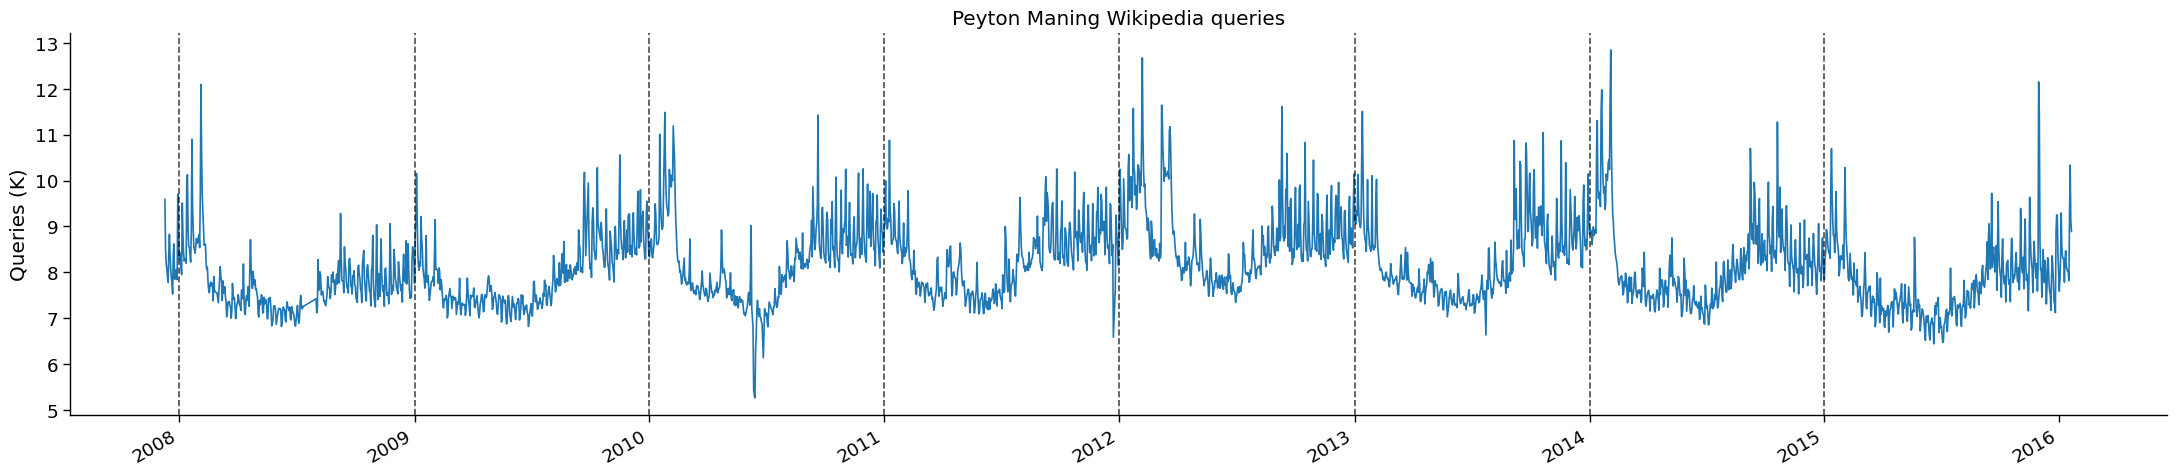

In [5]:
# Vars
# Unique years we have in the dataset:
min_year = np.unique(np.array(pm_df["timestamp"], dtype= 'datetime64[Y]')).min().astype(datetime).year
max_year = np.unique(np.array(pm_df["timestamp"], dtype= 'datetime64[Y]')).max().astype(datetime).year

pm_df.set_index(pd.to_datetime(pm_df["timestamp"]))["value"].plot()
# Add vertical lines at each year to better visualize the yearly seasonality
for i  in range(min_year+1, max_year):
    plt.axvline(datetime(i,1,1), color='k', linestyle='--', alpha=0.7)
plt.title("Peyton Maning Wikipedia queries")
plt.xlabel("")
plt.ylabel("Queries (K)")
plt.tight_layout()

In [6]:
np.unique(np.array(pm_df["timestamp"], dtype= 'datetime64[M]'))

array(['2007-12', '2008-01', '2008-02', '2008-03', '2008-04', '2008-05',
       '2008-06', '2008-07', '2008-08', '2008-09', '2008-10', '2008-11',
       '2008-12', '2009-01', '2009-02', '2009-03', '2009-04', '2009-05',
       '2009-06', '2009-07', '2009-08', '2009-09', '2009-10', '2009-11',
       '2009-12', '2010-01', '2010-02', '2010-03', '2010-04', '2010-05',
       '2010-06', '2010-07', '2010-08', '2010-09', '2010-10', '2010-11',
       '2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05',
       '2011-06', '2011-07', '2011-08', '2011-09', '2011-10', '2011-11',
       '2011-12', '2012-01', '2012-02', '2012-03', '2012-04', '2012-05',
       '2012-06', '2012-07', '2012-08', '2012-09', '2012-10', '2012-11',
       '2012-12', '2013-01', '2013-02', '2013-03', '2013-04', '2013-05',
       '2013-06', '2013-07', '2013-08', '2013-09', '2013-10', '2013-11',
       '2013-12', '2014-01', '2014-02', '2014-03', '2014-04', '2014-05',
       '2014-06', '2014-07', '2014-08', '2014-09', 

### Identify frequency

In [7]:
unique_date = pm_df["timestamp"].nunique()
print(f"{unique_date: ,.0f}") 

 2,905


## 2) Anomaly Detection
By default, identify anomalies based on a 99% prediction interval. Observations that fall outside this interval are considered anomalies.

In [8]:
timegpt = TimeGPT(token=TOKEN)
timegpt_anomalies_df = timegpt.detect_anomalies(pm_df, 
                                                time_col="timestamp", 
                                                target_col="value", 
                                                freq="D",
                                                level=99)
timegpt_anomalies_df

INFO:nixtlats.timegpt:Validating inputs...
INFO:nixtlats.timegpt:Preprocessing dataframes...


INFO:nixtlats.timegpt:Calling Anomaly Detector Endpoint...


ApiError: status_code: 429, body: {'data': None, 'message': 'Too many requests', 'details': 'You have reached your request limit, email ops@nixtla.io to continue using the API', 'code': 'A20', 'requestID': 'AU7R6L2QQ8', 'support': 'If you have questions or need support, please email ops@nixtla.io'}

In [ ]:
timegpt_anomalies_df["anomaly"].value_counts()

anomaly
0    2839
1      94
Name: count, dtype: int64

In [ ]:
timegpt.plot(pm_df, 
            timegpt_anomalies_df,
            time_col='timestamp', 
            target_col='value')

TypeError: xlabel() missing 1 required positional argument: 'xlabel'

You can include `date_features`

In [ ]:
timegpt_anomalies_df_x = timegpt.detect_anomalies(
    pm_df, time_col='timestamp', 
    target_col='value', 
    freq='D', 
    date_features=True,
    level=99.99,
)
timegpt.plot(
    pm_df, 
    timegpt_anomalies_df_x,
    time_col='timestamp', 
    target_col='value',
)

## 3) Anomaly Detection with Exogenous variables

In [10]:
df = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/electricity-short-with-ex-vars.csv')
df

,unique_id,ds,y,Exogenous1,Exogenous2,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,BE,2016-12-01 00:00:00,72.0000,"61,507.0000","71,066.0000",0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
1,BE,2016-12-01 01:00:00,65.8000,"59,528.0000","67,311.0000",0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
2,BE,2016-12-01 02:00:00,59.9900,"58,812.0000","67,470.0000",0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
3,BE,2016-12-01 03:00:00,50.6900,"57,676.0000","64,529.0000",0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
4,BE,2016-12-01 04:00:00,52.5800,"56,804.0000","62,773.0000",0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...
3595,PJM,2018-12-23 19:00:00,32.4620,"98,288.0000","11,711.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3596,PJM,2018-12-23 20:00:00,32.0522,"97,194.0000","11,637.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3597,PJM,2018-12-23 21:00:00,27.6323,"94,319.0000","11,433.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
3598,PJM,2018-12-23 22:00:00,24.7461,"90,106.0000","11,108.0000",0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [11]:
df["unique_id"].nunique()

5